<a href="https://colab.research.google.com/github/wolframalexa/humanities-data-analysis/blob/main/chap5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
# book code

import gzip
import pandas as pd
import urllib.request

url = 'https://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/5-stats/GSS7214_R5.DTA.gz'
data = urllib.request.urlopen(url);
data = gzip.open(data)

# we restrict this (very large) dataset to the variables of interest
columns = ['id', 'year', 'age', 'sex', 'race', 'reg16', 'degree',
               'realrinc', 'readfict']
df = pd.read_stata(data, columns=columns)

In [163]:
df = df.loc[df['year'].isin({1998, 2000, 2002})]

# limit dataset to exclude records from individuals who refused to report their income
df = df.loc[df['realrinc'].notnull()]

In [164]:
# adjust for inflation
cpi2015_vs_1986 = 236.7 / 109.6
assert df['realrinc'].astype(float).median() < 24000  # reality check
df['realrinc2015'] = cpi2015_vs_1986 * df['realrinc'].astype(float)

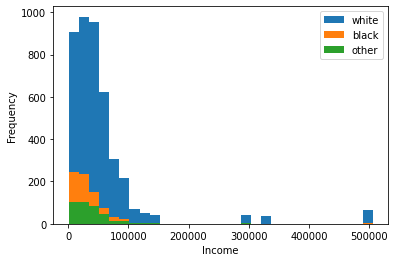

In [165]:
import matplotlib.pyplot as plt
df.groupby('race')['realrinc2015'].plot(kind='hist', bins=30)
plt.xlabel('Income')
plt.legend();

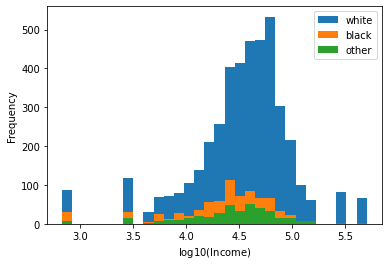

In [166]:
# use logarithm to generate plot
import numpy as np

df['realrinc2015_log10'] = np.log10(df['realrinc2015'])
df.groupby('race')['realrinc2015_log10'].plot(kind='hist', bins=30)
plt.xlabel(r'$\log10(\mathrm{Income})$')
plt.legend();


In [167]:
print("Max to min ratio", df['realrinc2015'].max() / df['realrinc2015'].min())

print("Mean income", df['realrinc2015'].mean())

print("Median income", df['realrinc2015'].median())

Max to min ratio 749.1342599999999
Mean income 51296.74902490707
Median income 37160.92814781022


In [168]:
df_bachelor = df[df['degree'] == 'bachelor']
# observed=True instructs pandas to ignore categories
# without any observations
df_bachelor.groupby(['year', 'degree'], observed=True)['realrinc2015'].agg(['size', 'mean', 'median'])

,,size,mean,median
year,degree,,,
1998,bachelor,363,63805.508302,48359.364964
2000,bachelor,344,58819.407571,46674.821168
2002,bachelor,307,85469.227956,50673.992929


In [169]:
readfict_sample = df.loc[df['readfict'].notnull()].sample(8)['readfict']
readfict_sample = readfict_sample.replace(['no', 'yes'], [0, 1])
readfict_sample

35869    1
36509    1
36928    1
41520    0
35545    1
37349    1
36447    1
35965    1
Name: readfict, dtype: int64

In [170]:
print("Mean:", readfict_sample.mean())
print("Median:", readfict_sample.median())

Mean: 0.875
Median: 1.0


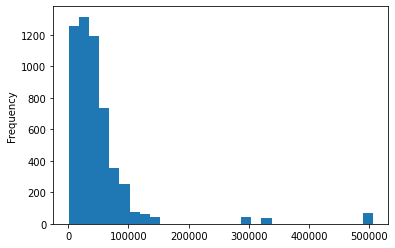

In [171]:
df['realrinc2015'].plot(kind='hist', bins=30); # all respondents household income

In [172]:
df.groupby('degree')['realrinc2015'].mad().round()

df_bachelor_or_more = df[df['degree'].isin(['bachelor', 'graduate'])]
df_bachelor_or_more.groupby(['degree', 'readfict'], observed=True)['realrinc2015'].mad().round()

degree    readfict
bachelor  yes          48908.0
          no          119523.0
graduate  yes          82613.0
          no          133028.0
Name: realrinc2015, dtype: float64

In [173]:
df_bachelor_or_more.groupby(['degree', 'readfict'], observed=True)['realrinc2015'].mean().round()

degree    readfict
bachelor  yes          71251.0
          no          139918.0
graduate  yes         113125.0
          no          153961.0
Name: realrinc2015, dtype: float64

In [174]:
import collections
import scipy.stats

group1 = ['high school', 'high school', 'high school', 'high school', 'high school',
          'high school', 'bachelor', 'bachelor']
group2 = ['lt high school', 'lt high school', 'lt high school', 'lt high school',
          'high school', 'junior college', 'bachelor', 'graduate']
group3 = ['lt high school', 'lt high school', 'high school', 'high school',
          'junior college', 'junior college', 'bachelor', 'graduate']


# Calculate the entropy of the empirical distribution over degree
# types for each group
for n, group in enumerate([group1, group2, group3], 1):
    degree_counts = list(collections.Counter(group).values())
    H = scipy.stats.entropy(degree_counts)
    print(f'Group {n} entropy: {H:.1f}')

Group 1 entropy: 0.6
Group 2 entropy: 1.4
Group 3 entropy: 1.6


In [175]:
df.groupby('reg16')['degree'].apply(lambda x: scipy.stats.entropy(x.value_counts()))
# new england has more educational diversity than other american regions

reg16
foreign            1.505782
new england        1.345351
middle atlantic    1.321904
e. nor. central    1.246287
w. nor. central    1.211067
south atlantic     1.261397
e. sou. central    1.196932
w. sou. central    1.290568
mountain           1.214591
pacific            1.283073
Name: degree, dtype: float64

In [176]:
df_subset_columns = ['age', 'realrinc2015_log10', 'reg16', 'degree']
min_income = 10_000
df_subset_index_mask = ((df['age'] >= 23) & (df['age'] <= 30) &
                        (df['degree'] == 'bachelor') &
                        (df['realrinc2015'] > min_income))
df_subset = df.loc[df_subset_index_mask, df_subset_columns]
# discard rows with NaN values
df_subset = df_subset[df_subset.notnull().all(axis=1)]
# age is an integer, not a float
df_subset['age'] = df_subset['age'].astype(int)

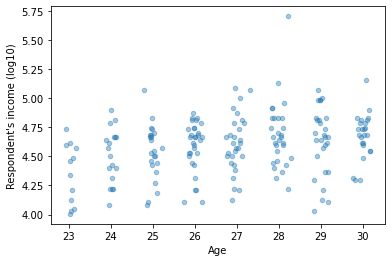

In [177]:
# Small amount of noise ("jitter") to respondents' ages makes
# discrete points easier to see
_jitter = np.random.normal(scale=0.1, size=len(df_subset))
df_subset['age_jitter'] = df_subset['age'].astype(float) + _jitter
ax = df_subset.plot(x='age_jitter', y='realrinc2015_log10', kind='scatter', alpha=0.4)
ax.set(ylabel="Respondent's income (log10)", xlabel="Age");

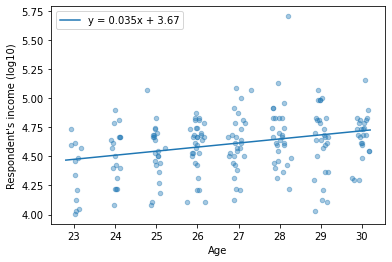

In [178]:
ax = df_subset.plot(x='age_jitter', y='realrinc2015_log10', kind='scatter', alpha=0.4)
slope, intercept = 0.035, 3.67
xs = np.linspace(23 - 0.2, 30 + 0.2)
label = f'y = {slope:.3f}x + {intercept:.2f}'
ax.plot(xs, slope * xs + intercept, label=label)
ax.set(ylabel="Respondent's income (log10)", xlabel="Age")
ax.legend();


In [179]:
df_subset[['age', 'realrinc2015_log10']].corr('kendall') # kendall correlation

,age,realrinc2015_log10
age,1.000000,0.204298
realrinc2015_log10,0.204298,1.000000


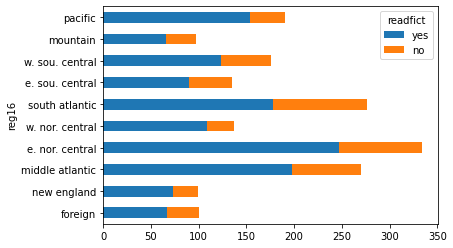

In [184]:
df_subset = df.loc[df['readfict'].notnull(), ['reg16', 'readfict']]
pd.crosstab(df_subset['reg16'], df_subset['readfict']).plot.barh(stacked=True);

In [186]:
df_subset = df.loc[df['readfict'].notnull(), ['reg16', 'readfict']]
pd.crosstab(df_subset['reg16'], df_subset['readfict'], margins=True)

readfict,yes,no,All
reg16,,,
foreign,67,33,100
new england,73,26,99
middle atlantic,198,72,270
e. nor. central,247,87,334
w. nor. central,109,28,137
south atlantic,178,98,276
e. sou. central,90,45,135
w. sou. central,123,53,176
mountain,66,31,97


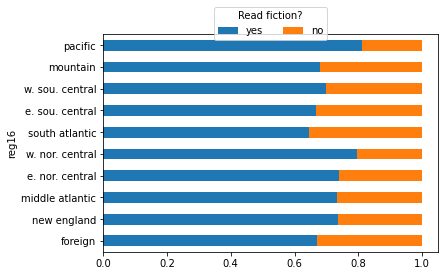

In [187]:
pd.crosstab(
    df_subset['reg16'], df_subset['readfict'], normalize='index').plot.barh(stacked=True);
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2, title="Read fiction?");

In [225]:
# mutual information
# Strategy:
# 1. Calculate the table of Pr(X=x, Y=y) from empirical frequencies
# 2. Calculate the marginal distributions Pr(X=x)Pr(Y=y)
# 3. Combine above quantities to calculate the mutual information.

joint = pd.crosstab(df_subset['reg16'], df_subset['readfict'], normalize='all')

# construct a table of the same shape as joint with the relevant
# values of Pr(X = x)Pr(Y = y)
proba_readfict, proba_reg16 = joint.sum(axis=0), joint.sum(axis=1)
denominator = np.outer(proba_reg16, proba_readfict)

mutual_information = (joint * np.log(joint / denominator)).sum().sum()
print(mutual_information)

0.006902379486166968


In [189]:
url = 'https://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/5-stats/tate.csv.gz'
data = urllib.request.urlopen(url);
data = gzip.open(data)

tate = pd.read_csv(data)
# remove objects for which no suitable year information is given:
tate = tate[tate['year'].notnull()]
tate = tate[tate['year'].str.isdigit()]
tate['year'] = tate['year'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [190]:
# my code
# Easy

mean_width = tate['width'].mean()
med_width = tate['width'].median()
mean_height = tate['height'].mean()
med_height = tate['height'].median()

tate['area'] = tate['width'] * tate['height']
mean_area = tate['area'].mean()
med_area = tate['area'].median()

print("Width: Median (", med_width, "), Mean (", mean_width, ")")
print("Height: Median (", med_height, "), Mean (", mean_height, ")")
print("Area: Median (", med_area, "), Mean (", mean_area, ")")

Width: Median ( 189.0 ), Mean ( 320.9543617578924 )
Height: Median ( 172.0 ), Mean ( 301.2784118771031 )
Area: Median ( 25750.0 ), Mean ( 219918.85831684674 )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


The median is likely a better statistic since a few very large paintings will skew the mean, particularly in area because of the quadratic.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Log(width)')

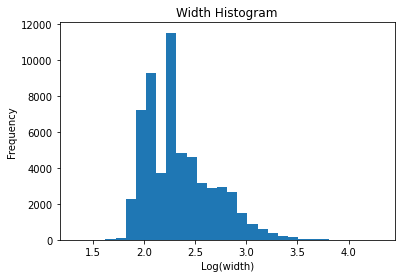

In [191]:
tate['width_log10'] = np.log10(tate['width'])
tate['width_log10'].plot(kind='hist', bins=30)
plt.title("Width Histogram")
plt.xlabel("Log(width)")

Text(0.5, 0, 'Log(Area)')

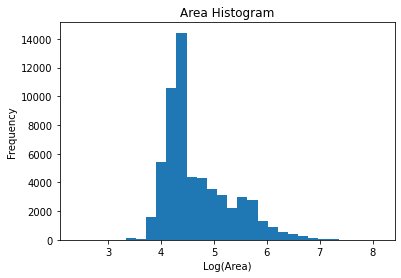

In [192]:
tate['area_log10'] = np.log10(tate['area'])
tate['area_log10'].plot(kind='hist', bins=30)
plt.title("Area Histogram")
plt.xlabel("Log(Area)")

Text(0.5, 0, 'Log(height)')

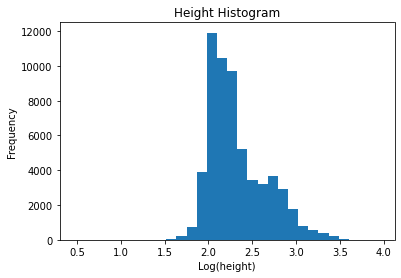

In [193]:
tate['height_log10'] = np.log10(tate['height'])
tate['height_log10'].plot(kind='hist', bins=30)
plt.title("Height Histogram")
plt.xlabel("Log(height)")

In [194]:
# compute range of height/width
range_height = tate['height'].max() - tate['height'].min()
range_width = tate['width'].max() - tate['width'].min()
print("Height:", range_height)
print("Width:", range_width)

Height: 8917
Width: 19979


Range is a useful parameter to understand the dispersion of the data and the different scales of paintings that exist - however the maximum height and width likely occur for different paintings so presenting the data like so could be misleading.

Text(0, 0.5, 'Work Area (log10)')

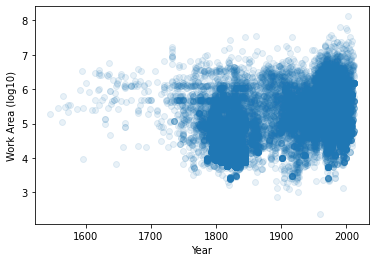

In [195]:
# Moderate
plt.scatter(tate['year'], tate['area_log10'], alpha=0.1)
plt.xlabel("Year")
plt.ylabel("Work Area (log10)")

In the second half of the 19th century, there are more artworks, as evidenced by a denser dot population. The artworks that do exist also have more varied and extreme sizes.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


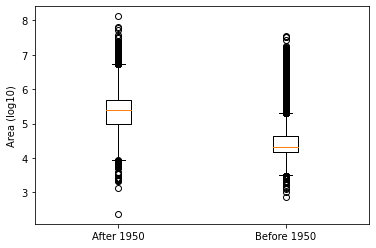

In [196]:
# split into before and after 1950
tate_after_50 = tate[tate['year'] > 1950]
tate_bef_50 = tate[tate['year'] <= 1950]
data_to_plot = [tate_after_50['area_log10'], tate_bef_50['area_log10']]

fig, ax = plt.subplots()
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['After 1950', 'Before 1950'])
plt.ylabel("Area (log10)")
plt.show()

Before 1950, paintings tended to be smaller. We notice, however, that there are a considerable number of outliers that, if included, may raise the mean and median painting area prior to 1950.

[(-4000.0, 4000.0), (-4000.0, 4000.0)]

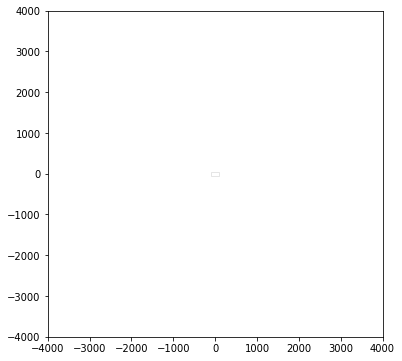

In [197]:
import matplotlib

def create_rectangle(width, height):
  return matplotlib.patches.Rectangle(
      (-(width / 2), -(height / 2)), width, height,
      fill=False, alpha=0.1)

fig, ax = plt.subplots(figsize=(6,6))
row = tate.sample(n=1).iloc[0]
ax.add_patch(create_rectangle(row['width'], row['height']))
ax.set(xlim=(-4000,4000), ylim=(-4000,4000))

Text(0.5, 1.0, 'Artworks after 1950')

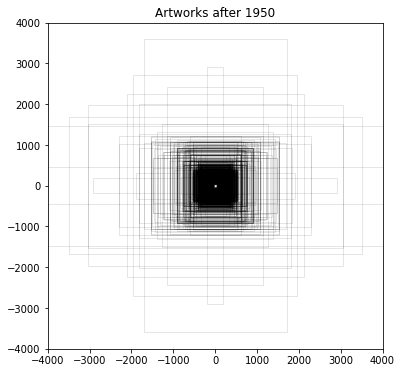

In [198]:
fig, ax = plt.subplots(figsize=(6,6))
row = tate_after_50.sample(n=2000)
for i in range(0,2000):
  element = row.iloc[i]
  ax.add_patch(create_rectangle(element['width'], element['height']))
ax.set(xlim=(-4000,4000), ylim=(-4000,4000))
plt.title("Artworks after 1950")

Text(0.5, 1.0, 'Artworks before 1950')

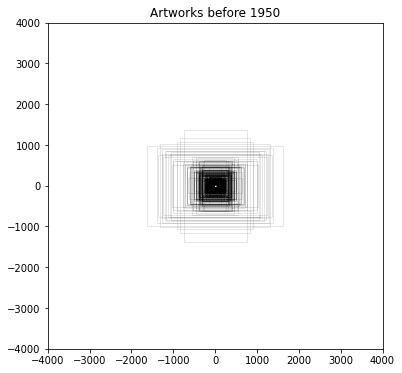

In [199]:
fig, ax = plt.subplots(figsize=(6,6))
row = tate_bef_50.sample(n=2000)
for i in range(0,2000):
  element = row.iloc[i]
  ax.add_patch(create_rectangle(element['width'], element['height']))
ax.set(xlim=(-4000,4000), ylim=(-4000,4000))
plt.title("Artworks before 1950")

This visualization shows what the boxplot hints at - paintings have gotten far bigger and more extreme after 1950.

In [200]:
# Challenging
# entropy of different artists
# tate['artist'].apply(lambda x: scipy.stats.entropy(x))

all_artists = list(collections.Counter(tate['artist']).values())
H = scipy.stats.entropy(all_artists)
print(f'Artist entropy: {H:.1f}')

Artist entropy: 2.9


In [201]:
post50_artists = list(collections.Counter(tate_after_50['artist']).values())
H_post50 = scipy.stats.entropy(post50_artists)

pre50_artists = list(collections.Counter(tate_bef_50['artist']).values())
H_pre50 = scipy.stats.entropy(pre50_artists)
print(f'Artist entropy before 1950: {H_pre50:.1f}')
print(f'Artist entropy after 1950: {H_post50:.1f}')

Artist entropy before 1950: 1.4
Artist entropy after 1950: 5.9


After 1950, the artists in the Tate's collection become more diverse. This can be attributed to better conservation practices, increased diversity of artists (due to the increased participation of artists from different regions, cultural groups, genders, etc), and easier acquisition of contemporary art.

In [243]:
numrows = tate.shape[0]
emotions = np.zeros(numrows,)
concepts = np.zeros(numrows,)
nature = np.zeros(numrows,)
abstraction = np.zeros(numrows,)

tate = tate.dropna(subset=['subject'])

i = 0
for index, row in tate.iterrows():
  subjects = row['subject'].split(',')
  if 'emotions' in subjects:
    emotions[i] += 1
  if ' concepts and ideas' in subjects:
    concepts[i] += 1
  if 'abstraction' in subjects:
    abstraction[i] += 1
  if 'nature' in subjects:
    nature[i] += 1
  i += 1

In [242]:
# calculate mutual information
tate['is_emotion'] = emotions
tate['is_concepts'] = concepts

table = pd.crosstab(tate['is_emotion'], tate['is_concepts'], normalize='all')

prob_emotion, prob_concepts = table.sum(axis=0), table.sum(axis=1)
denominator = np.outer(prob_emotion, prob_concepts)
mutual_information = (table * np.log(table / denominator)).sum().sum()
print(mutual_information)

0.39016091147325327


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [244]:
# calculate mutual information for nature and abstraction
tate['is_nature'] = nature
tate['is_abstract'] = abstraction

table = pd.crosstab(tate['is_nature'], tate['is_abstract'], normalize='all')

prob_nature, prob_abstract = table.sum(axis=0), table.sum(axis=1)
denominator = np.outer(prob_nature, prob_abstract)
mutual_information = (table * np.log(table / denominator)).sum().sum()
print(mutual_information)

# I wish I had read the hint sooner about converting to document term matrix

1.293857857452025


High mutual information means that emotions and concepts are often present in the same work.

In [256]:
# people prefer to make 4x3 artwork
tate['ratio'] = tate['height']/tate['width']

works_4by3 = tate[(tate['ratio'] < 1.4) & (tate['ratio'] > 1.3) | ((tate['ratio'] < 0.78) & (tate['ratio'] > 0.7))]
percent_4by3 = works_4by3.shape[0]/tate.shape[0]
print(percent_4by3)

0.2236080802418467


Only 22% of works are in a 4/3 ratio, which does not seem like an overwhelming preference.

In [260]:
# more tall pieces than wide pieces

tate['tall'] = (tate['height'] > tate['width'])
tate['wide'] = (tate['height'] < tate['width'])

tate.tall.value_counts()

False    28374
True     21575
Name: tall, dtype: int64

In [261]:
tate.wide.value_counts()

True     27683
False    22266
Name: wide, dtype: int64

There are approximately the same number of tall and wide paintings - if anything, there are more wide than tall paintings. I think this would be due to painting landscapes.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Text(0, 0.5, 'Width (log10)')

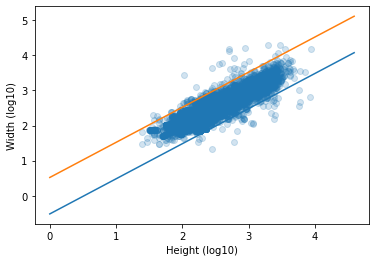

In [274]:
# people are using the golden ratio
x = np.arange(100)
golden = np.log(1/1.681 * x) # golden ratio for tall paintings
golden2 = np.log(1.681 * x) # golden ratio for wide paintings

plt.scatter(tate['height_log10'], tate['width_log10'], alpha=0.2)
plt.plot(np.log(x), golden)
plt.plot(np.log(x), golden2)
plt.xlabel("Height (log10)")
plt.ylabel("Width (log10)")

Most paintings, whether wide or tall, are close to the golden ratio.